# Analysis of noisy purification

In [1]:
import numpy as np
import math
import importlib as imp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdmn
from scipy.optimize import fsolve

import main_1GnB as main

### Erasure
Same $J$, different $p$: $(1-\alpha)p$. This means scaling $a,b,c,d$ by $(1-\alpha)$.

### Depolarization
Same $p$, different $J$: $J + \beta(\beta-2) * (J-0.25)$. This means same $c,d$ and scale $a,b$ by $1+\beta*(\beta-2)$:
$$ a_\mathrm{depol} = \left(1+\beta(\beta-2)\right)a$$
$$ b_\mathrm{depol} = (1+\beta(\beta-2))b$$

---
---
## Output fidelity and success probability

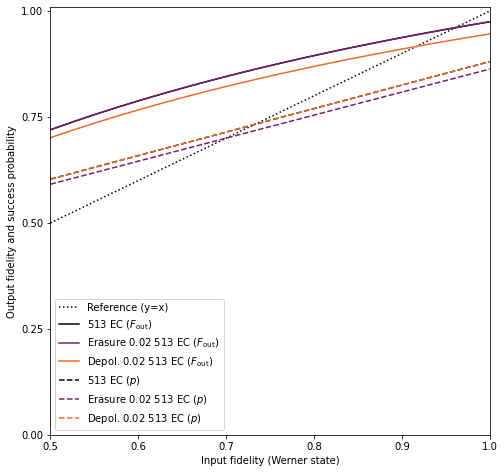

In [2]:
imp.reload(main)

prob_failure = 0.02
policy = '513 EC'


### Calculations

policy_names = [policy, 'Erasure %.2f '%prob_failure+policy, 'Depol. %.2f '%prob_failure+policy]

F_new = 0.9
rho_new = np.diag([F_new, (1-F_new)/3, (1-F_new)/3, (1-F_new)/3])
num_new_links = 5

main.policies_plot(policy_names, rho_new, num_new_links)

---
---
## Buffering performance

['Erasure 0.00 DEJMPS', 'Erasure 0.10 DEJMPS', 'Depol. 0.00 DEJMPS', 'Depol. 0.20 DEJMPS']


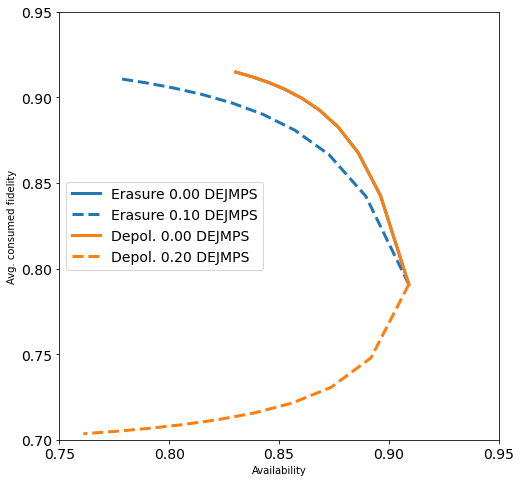

In [3]:
varying_param = 'q_purif'
n = 5
p_gen = 1
rho00 = 0.9
rho_new = rho_new = np.diag([rho00, (1-rho00)/3, (1-rho00)/3, (1-rho00)/3])
q_purif = np.linspace(0,1,10)
pur_after_swap = False
Gamma = 0.02
p_cons = 0.1
policy = 'DEJMPS'
alpha1 = 0
alpha2 = 0.1
beta1 = 0
beta2 = 0.2

main.AFplot_noisy(varying_param, n, p_gen, rho_new, q_purif, pur_after_swap, Gamma,
             p_cons, policy, alpha1, alpha2, beta1, beta2)

In [6]:
imp.reload(main)
main.AFplot_noisy_interactive()

interactive(children=(IntSlider(value=5, description='n', layout=Layout(width='60%'), max=15, min=1), FloatSli…

---
---
## Fixed availability A, with fixed $q=1$

In [51]:
n = 5

# GEN
p_gen = 1
F_new = 0.85
rho_new = np.diag([F_new, (1-F_new)/3, (1-F_new)/3, (1-F_new)/3])

# PURIF
policy = '513 EC'
pur_after_swap = False

# NOISE
Gamma = 0.1

# CONS
p_cons = 0.2

# Experiment
colors = ['tab:blue', 'tab:orange']
savefig = True

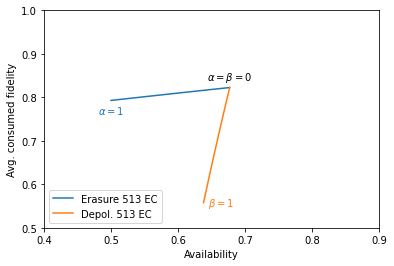

In [52]:
## THEORY ##

imp.reload(main)

q_purif = 1
noise_vec = np.linspace(0,1,50)
Fcons_vecs = [[None for _ in noise_vec] for _ in range(2)]
A_vecs = [[None for _ in noise_vec] for _ in range(2)]

for idx_noise, noise in enumerate(noise_vec):
    _policy_names = ['Erasure %.2f '%noise+policy, 'Depol. %.2f '%noise+policy,]
    for idx_policy, _policy_name in enumerate(_policy_names):
        A, Fcons = main.analytical_availability_Fcons(n, p_gen, rho_new, q_purif,
                                                main.policy_label_to_function(_policy_name),
                                                pur_after_swap, Gamma, p_cons)
        Fcons_vecs[idx_policy][idx_noise] = Fcons
        A_vecs[idx_policy][idx_noise] = A

## PLOT ##
_policy_names = ['Erasure '+policy, 'Depol. '+policy,]
for idx_policy, _policy_name in enumerate(_policy_names):
    plt.plot(A_vecs[idx_policy], Fcons_vecs[idx_policy], color=colors[idx_policy],
             label=_policy_name)

plt.xlim([0.4,0.9])
plt.ylim([0.5,1])

plt.xlabel(r'Availability')
plt.ylabel(r'Avg. consumed fidelity')
plt.legend(loc='lower left')
plt.text(A_vecs[0][0], Fcons_vecs[0][0]*1.01, r'$\alpha=\beta=0$',
         horizontalalignment='center', verticalalignment='bottom')
plt.text(A_vecs[0][-1], Fcons_vecs[0][-1]*0.99, r'$\alpha=1$',
         horizontalalignment='center', verticalalignment='top',
         color=colors[0])
plt.text(A_vecs[1][-1]*1.01, Fcons_vecs[1][-1], r'$\beta=1$',
         horizontalalignment='left', verticalalignment='center',
         color=colors[1])

if savefig:
    filename = 'figs/noisy%s-q1-n%d-pg%.3f-rho00%.3f-rho11%.3f-rho22%.3f-Gamma%.3f-pc%.3f.pdf'%(policy,
                n, p_gen, rho_new[0][0], rho_new[1][1], rho_new[2][2], Gamma, p_cons)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
else:
    plt.show()

---
### CONCLUSIONS:
 1. We look at the DEJMPS policy with $q=1$ (to maximize avg. consumed fidelity). When increasing the level of noise (i.e., increasing $\alpha$ in the erasure noise model and increasing $\beta$ in the depolarizing noise model), both the availability and the avg. consumed fidelity decrease.
 2. Erasures seem to have a stronger impact on the availability than depolarizing noise, while depolarizing noise has a stronger impact on avg. consumed fidelity. The intuition is as follows. On the one hand, erasures are flagged and therefore decrease the probability of success of the protocol. This means that the buffer is emptied more often, therefore decreasing the availability. On the other hand, depolarizing noise is not flagged. Hence, the buffered memory is statistically replaced by junk (low-fidelity entanglement), although this buffered state remains available. This does not have a direct impact on the availability (it only affects it through future applications of the jump function) but it does have a direct and strong impact on the avg. consumed fidelity.
 3. When the level of noise is the same (i.e., when the probability of an error is the same, that is, $\alpha = 1-(1-\beta)^2$), the depolarizing model has a stronger effect on the avg. consumed fidelity: $\overline F_\mathrm{depol} \leq \overline F_\mathrm{erasure}$.
---